<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Изучение-данных." data-toc-modified-id="Изучение-данных.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Изучение данных.</a></span></li><li><span><a href="#Ресемплирование-по-часу" data-toc-modified-id="Ресемплирование-по-часу-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ресемплирование по часу</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Снижение-колебаний-временного-ряда." data-toc-modified-id="Снижение-колебаний-временного-ряда.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Снижение колебаний временного ряда.</a></span></li><li><span><a href="#Срез-недели-апреля." data-toc-modified-id="Срез-недели-апреля.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Срез недели апреля.</a></span></li><li><span><a href="#Срез-недели-июля." data-toc-modified-id="Срез-недели-июля.-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Срез недели июля.</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделим-данные-на-выборки" data-toc-modified-id="Разделим-данные-на-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделим данные на выборки</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Random-Forest-Regressor" data-toc-modified-id="Random-Forest-Regressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Random Forest Regressor</a></span></li><li><span><a href="#LightGBM-Regressor" data-toc-modified-id="LightGBM-Regressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM Regressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Изучение данных.

Подгружаем необходимые в проекте библиотеки

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split

warnings.filterwarnings('ignore')
import lightgbm as lgbm
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit 
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# открываем файл
try:
    data = pd.read_csv('G:\DataS\projects/taxi.csv', parse_dates=[0],  index_col=['datetime'])
except:
    data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0],  index_col=['datetime'])

In [3]:
MAX_LAG = 24
ROLLING_MEAN_SIZE = 100
RS = 12345

In [4]:
# выведем размеры датафрейма 
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [5]:
# открываем первые 5 строк датафрейма
display(data.head(5))

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

In [6]:
# Проверка на наличие пропусков в данных
data.isnull().sum()

num_orders    0
dtype: int64

In [7]:
# посмотрим на значения в количестве заказов
data.describe()

num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

In [8]:
# проверим хронологический порядок данных
display(data.index.is_monotonic)

True

### Ресемплирование по часу

В задании сказано после загрузки данных провести ресемплирование по одному часу.

In [9]:
data = data.resample('1H').sum() 

Без графиков никуда.

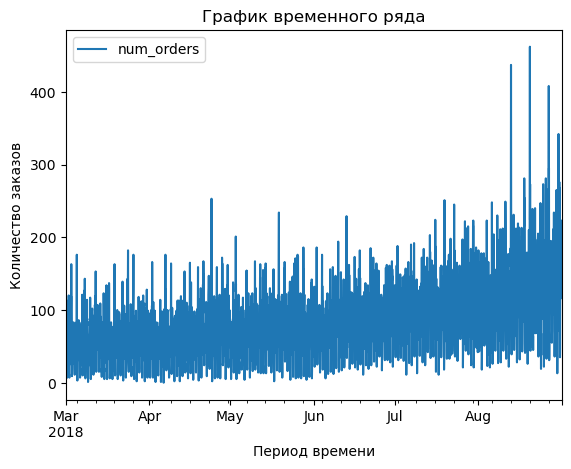

In [10]:
data.plot()

plt.title("График временного ряда")
plt.xlabel("Период времени")
plt.ylabel("Количество заказов")
plt.show()

В данных вроде бы все прекрасно:

☐ пропусков нет, 

☐ отрицательных данных по заказам тоже нет,

☐ временной ряд в хронологической последовательности. 

Возможно в столбце с количеством заказов есть аномалия (462 заказа!), но вдруг и такое бывает в "час-пик".

26496 строк с данными о заказах снятых с течением врмени.

По графику могу сказать только то, что есть выбивающиеся значения и судя по "загруженности" графика снятие данных производится с высокой частотой (каждый час после ресемплирования).

## Анализ

В связи с большой частотой снятия данных, для "сглаживания" графика попробую сжать данные до одного дня. Т.е. Количестов заказов за один день.

### Снижение колебаний временного ряда.

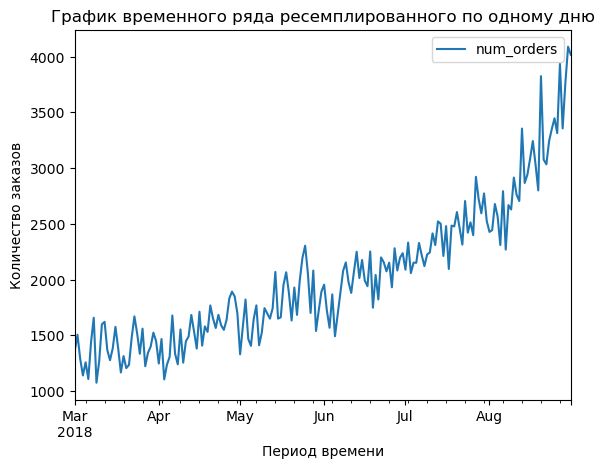

In [11]:
data.resample('1D').sum().plot() 
plt.title("График временного ряда ресемплированного по одному дню")
plt.xlabel("Период времени")
plt.ylabel("Количество заказов")
plt.show()

~Прекрасная кардиограмма~

Заметна тенденция (тренд) к увеличению заказов с апреля по июнь не сильная. С Июня по конец августа более заметная тенденция к увеличению.

По теории в яндекс Практикуме после ресемплирования идет скользящая среднняя. Так как я толком не поняла, что за анализ нужно провести, то решила идти по алгоритму из теории.

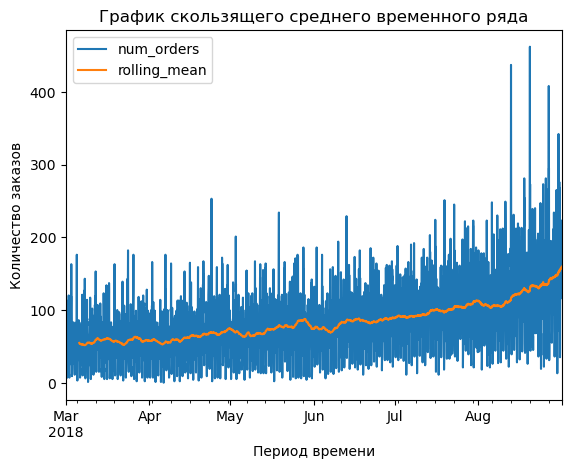

In [12]:
data_roll = data.copy()
data_roll['rolling_mean'] = data.rolling(120).mean()
data_roll.plot()
plt.title("График скользящего среднего временного ряда")
plt.xlabel("Период времени")
plt.ylabel("Количество заказов")
plt.show()

Долго подбирала значение скольжения (от 50 до 150 пробовала) но как-то решила остановиться на "Au" середине.

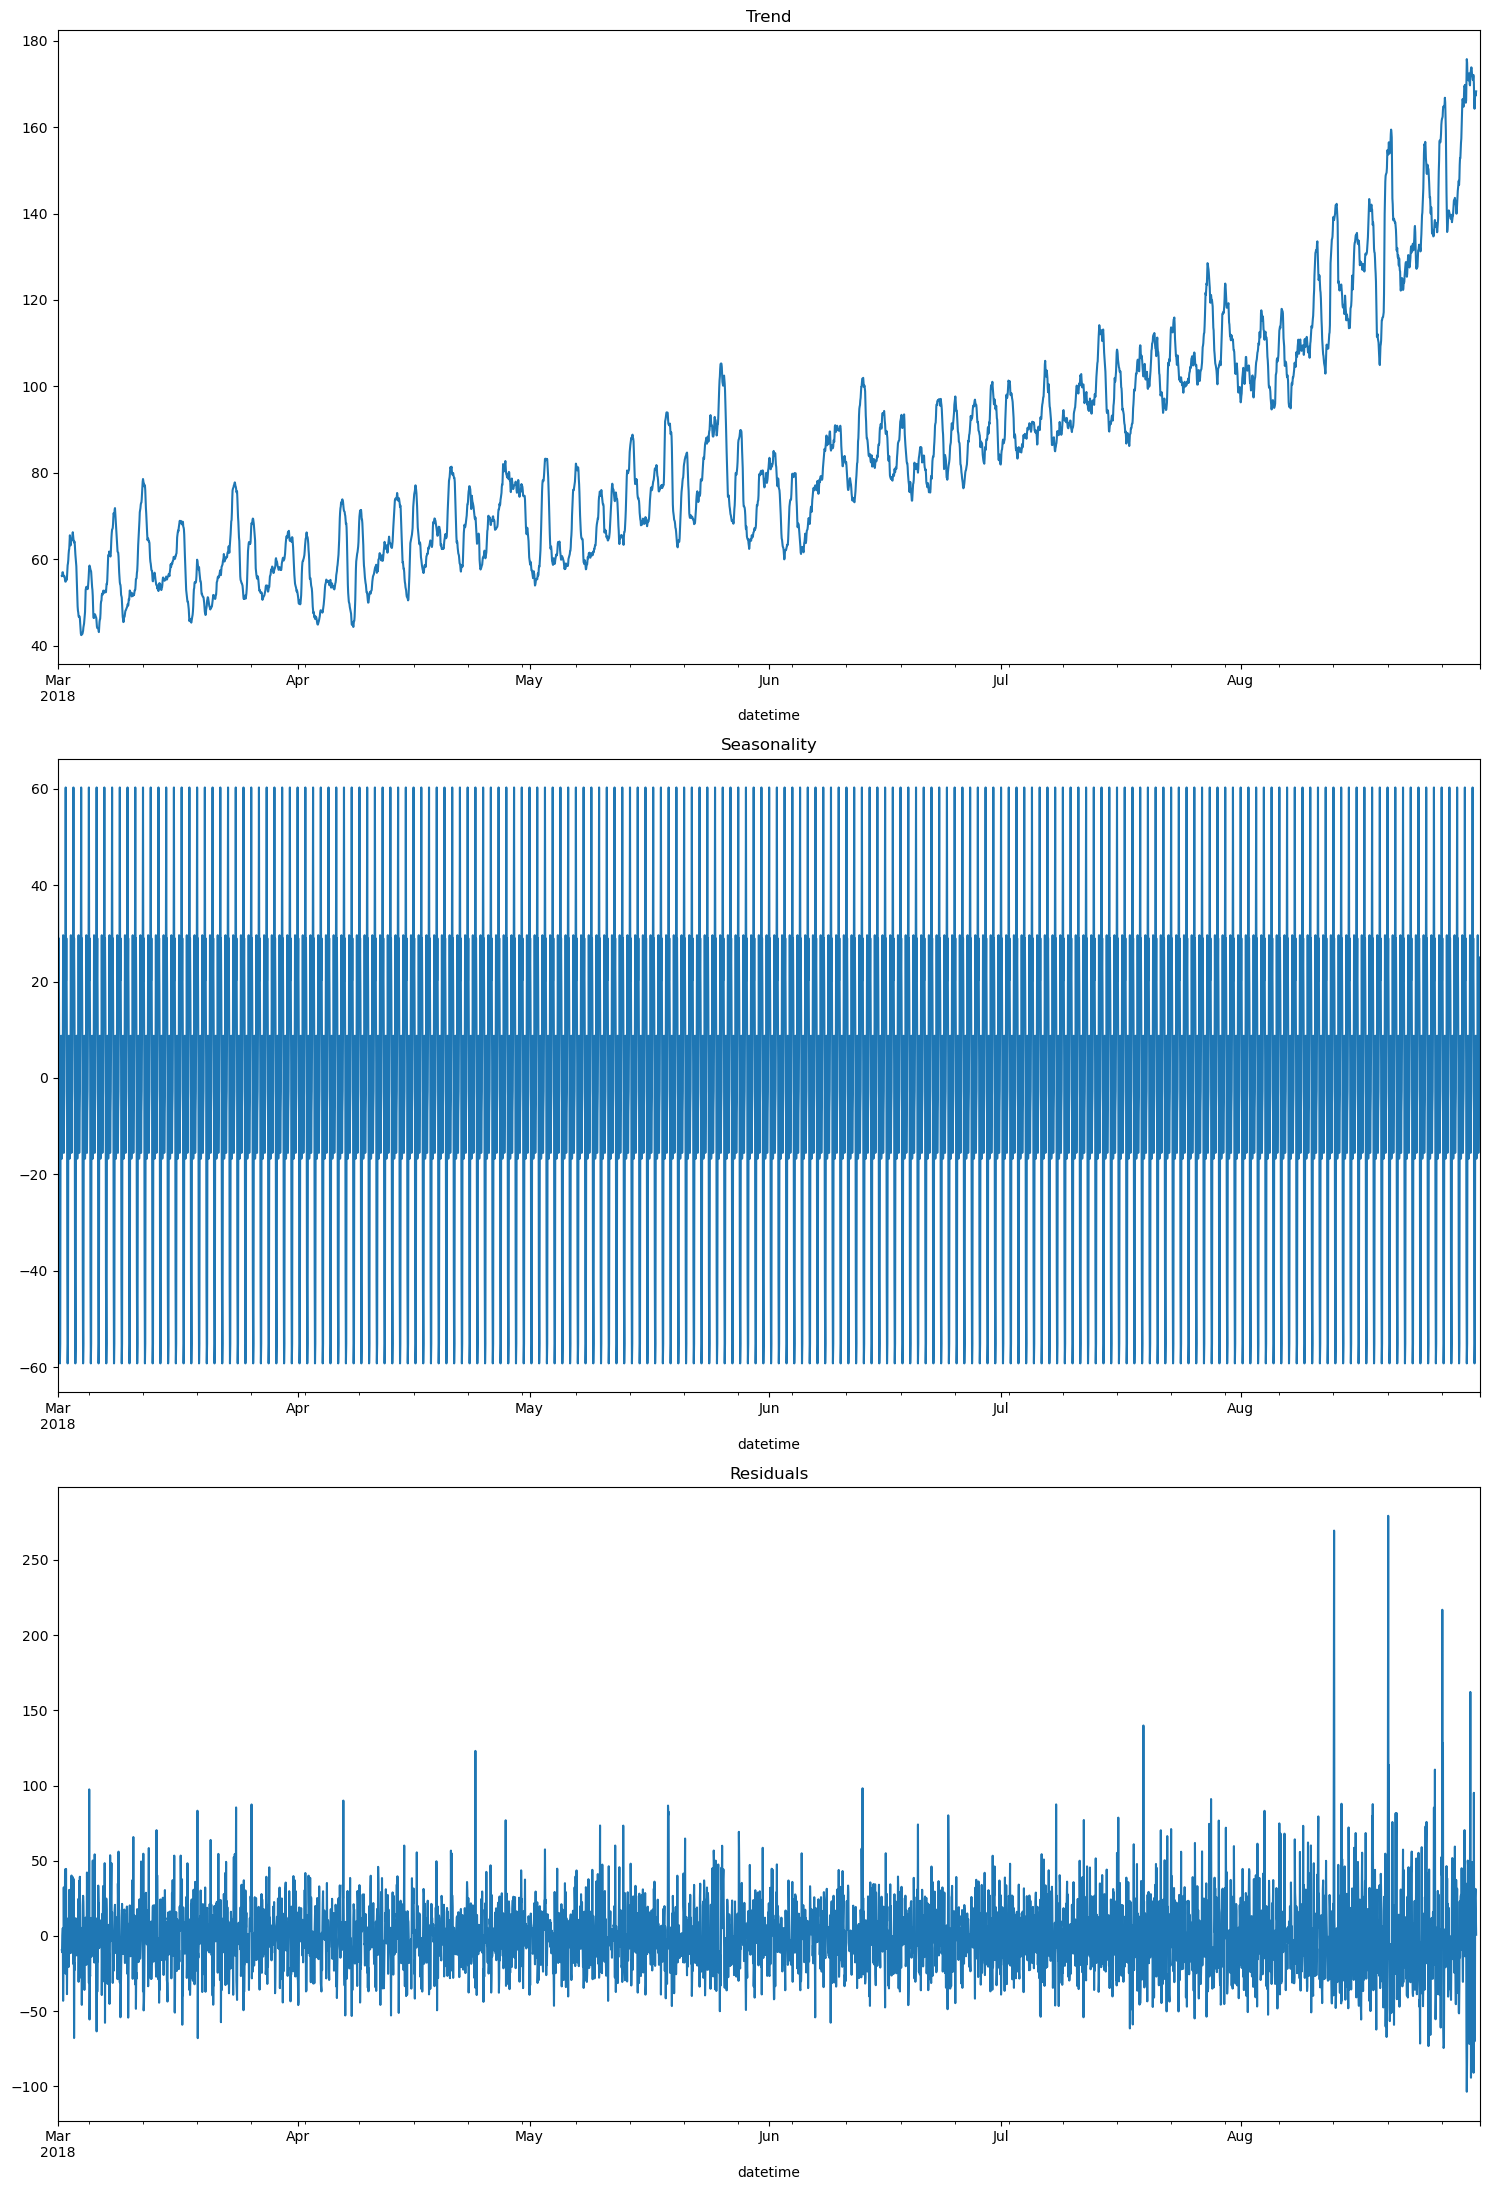

In [13]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 22))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca() (англ. get current axis,  получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд на увеличение стал более заметным.

Закономерность нужно рассмотреть детальнее либо зависит по неделям либо по дням.

Для этого попробую поработать со срезами временного ряда.

### Срез недели апреля.

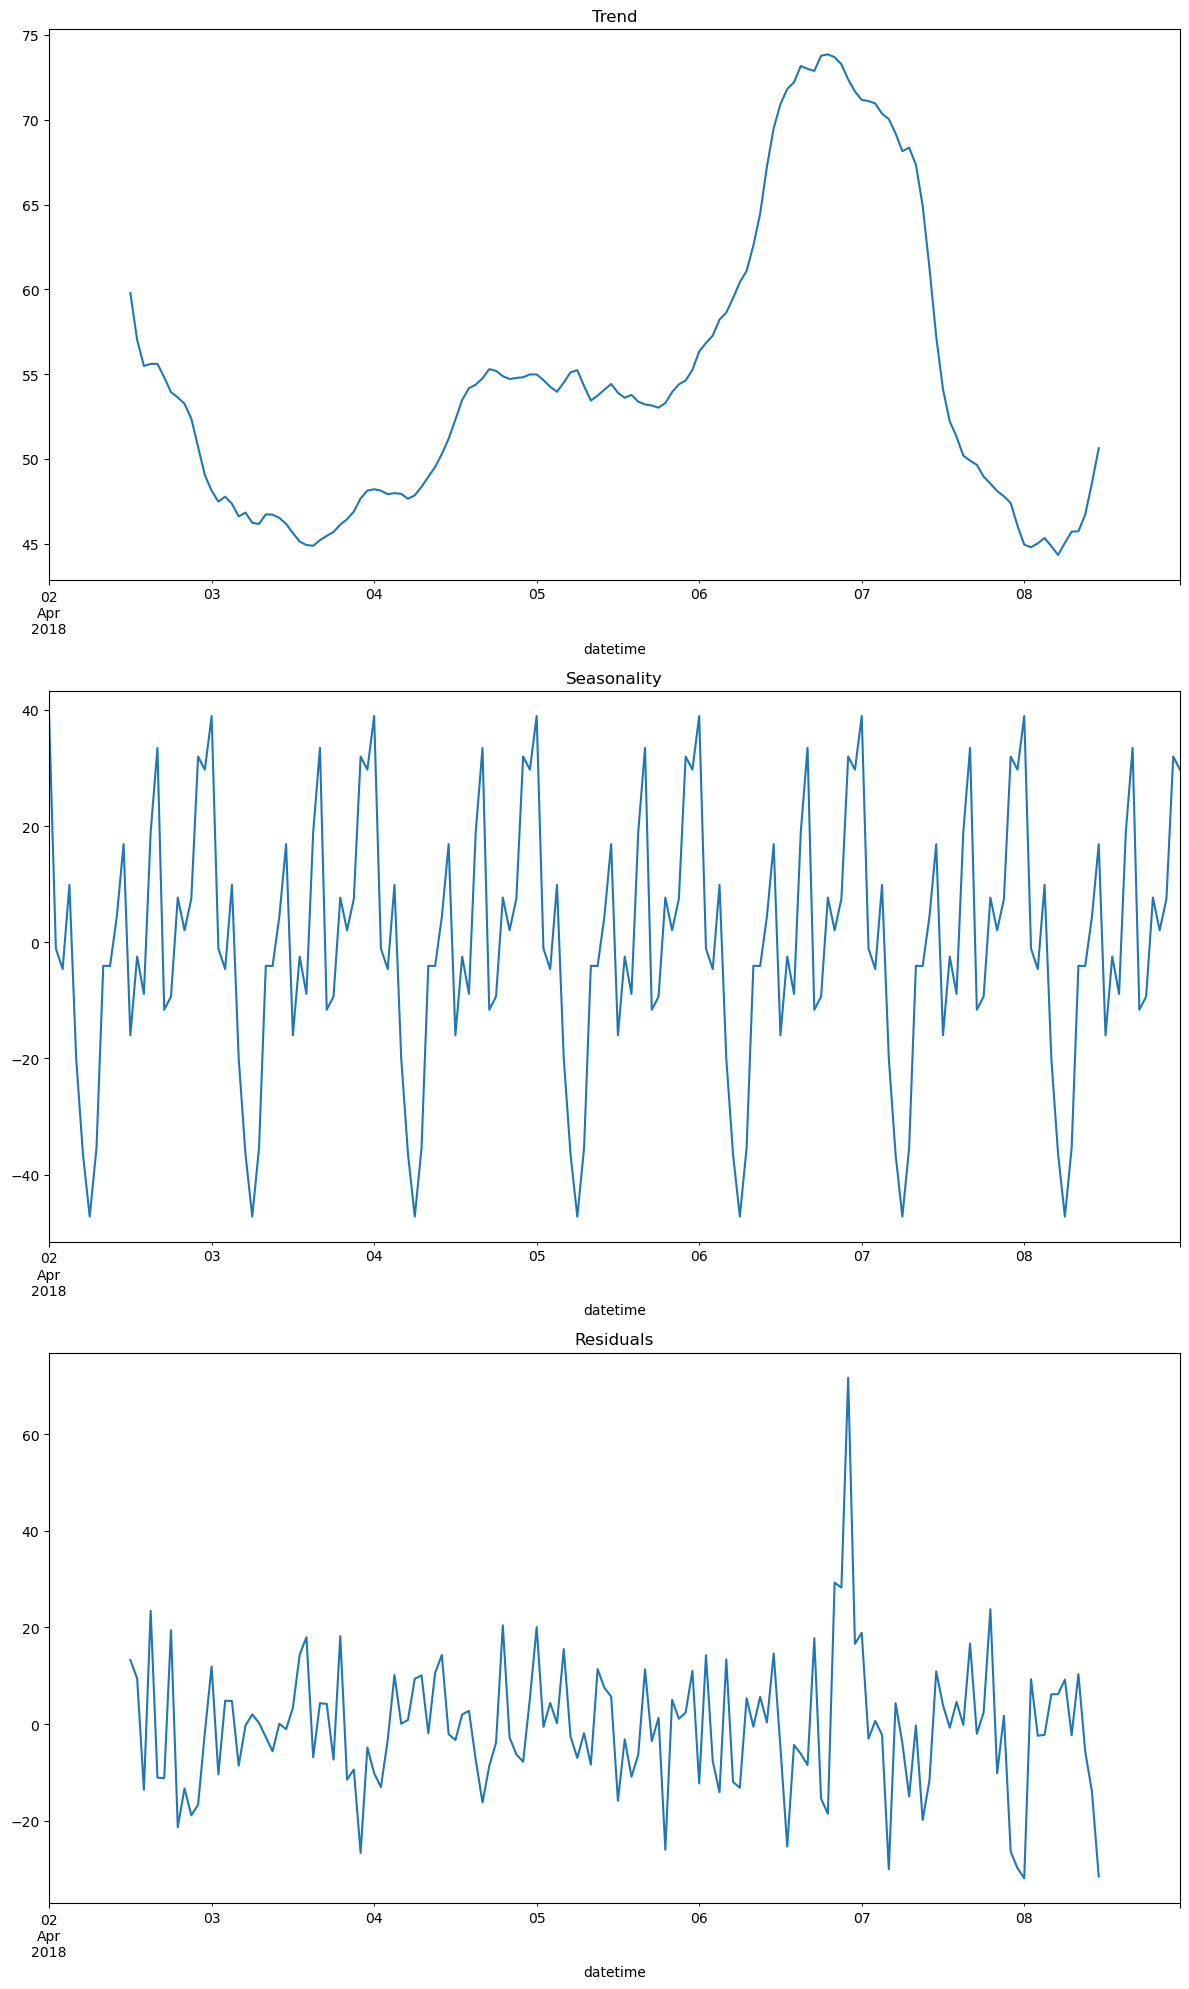

In [14]:
decomposed = seasonal_decompose(data['2018-04-02':'2018-04-08'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


Срез недели в апреле показал падение количества заказов в начале недели и яркое увеличение к пятнице и к выходным (взяла именно календарную неделю для чистоты эксперимента)

### Срез недели июля.

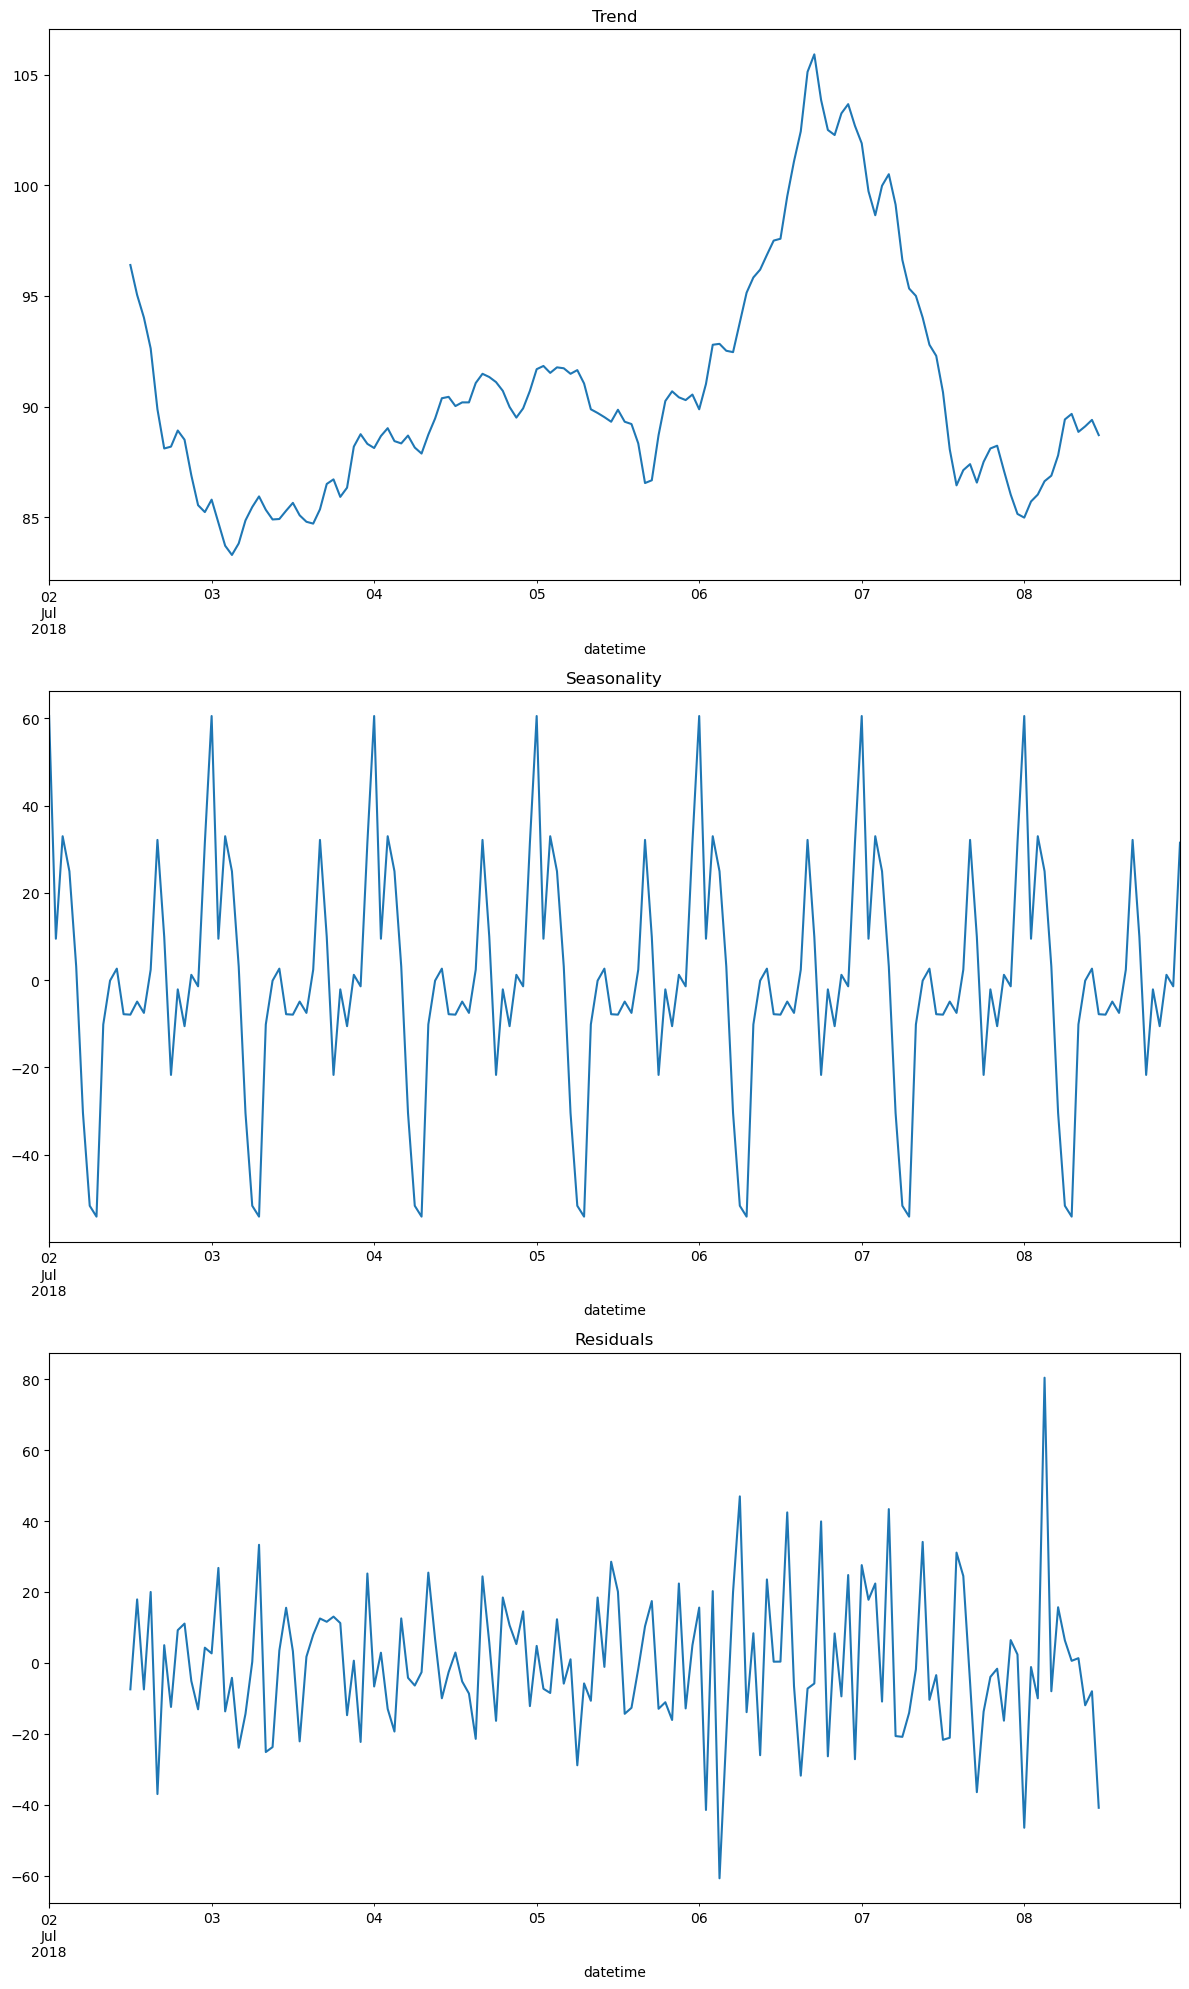

In [15]:
decomposed = seasonal_decompose(data['2018-07-02':'2018-07-08'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


Странности случаются и в июле тоже есть вплеск заказов, но только в субботу.

В обоих случаях есть сезонность от времени суток (день/ночь).

В задании не понятно, что за анализ нужен. По теории все что смогла-реализовала.


## Обучение

Перейдем к обучению. Мне надоела линейная регрессия - она всегда проигрывает среди моделей и порогово проходит заявленную метрику. Поэтому я возьму лидеров с предыдущего спринта это будет Случайный лес, CatBoostRegressor и LightGBM.


Добавим дополнительные признаки: день недели, час, отстающие значения и скользящие средние:

In [16]:
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

for lag in range(1, MAX_LAG + 1):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
data['rolling_mean'] = data['num_orders'].shift().rolling(ROLLING_MEAN_SIZE).mean()
data

num_orders  dayofweek  hour  lag_1  lag_2  lag_3  lag_4  \
datetime                                                                       
2018-03-01 00:00:00         124          3     0    NaN    NaN    NaN    NaN   
2018-03-01 01:00:00          85          3     1  124.0    NaN    NaN    NaN   
2018-03-01 02:00:00          71          3     2   85.0  124.0    NaN    NaN   
2018-03-01 03:00:00          66          3     3   71.0   85.0  124.0    NaN   
2018-03-01 04:00:00          43          3     4   66.0   71.0   85.0  124.0   
...                         ...        ...   ...    ...    ...    ...    ...   
2018-08-31 19:00:00         136          4    19  207.0  217.0  197.0  116.0   
2018-08-31 20:00:00         154          4    20  136.0  207.0  217.0  197.0   
2018-08-31 21:00:00         159          4    21  154.0  136.0  207.0  217.0   
2018-08-31 22:00:00         223          4    22  159.0  154.0  136.0  207.0   
2018-08-31 23:00:00         205          4    23  223.0  159.0  154.0  136.0   

                     lag_5  lag_6  lag_7  ...  lag_16  lag_17  lag_18  lag_19  \
datetime                                  ...                                   
2018-03-01 00:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 04:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
...                    ...    ...    ...  ...     ...     ...     ...     ...   
2018-08-31 19:00:00  133.0  166.0  136.0  ...    99.0   230.0   194.0   276.0   
2018-08-31 20:00:00  116.0  133.0  166.0  ...   268.0    99.0   230.0   194.0   
2018-08-31 21:00:00  197.0  116.0  133.0  ...    78.0   268.0    99.0   230.0   
2018-08-31 22:00:00  217.0  197.0  116.0  ...    35.0    78.0   268.0    99.0   
2018-08-31 23:00:00  207.0  217.0  197.0  ...    46.0    35.0    78.0   268.0   

                     lag_20  lag_21  lag_22  lag_23  lag_24  rolling_mean  
datetime                                                                   
2018-03-01 00:00:00     NaN     NaN     NaN     NaN     NaN           NaN  
2018-03-01 01:00:00     NaN     NaN     NaN     NaN     NaN           NaN  
2018-03-01 02:00:00     NaN     NaN     NaN     NaN     NaN           NaN  
2018-03-01 03:00:00     NaN     NaN     NaN     NaN     NaN           NaN  
2018-03-01 04:00:00     NaN     NaN     NaN     NaN     NaN           NaN  
...                     ...     ...     ...     ...     ...           ...  
2018-08-31 19:00:00   246.0   158.0   198.0   142.0    72.0        157.33  
2018-08-31 20:00:00   276.0   246.0   158.0   198.0   142.0        156.74  
2018-08-31 21:00:00   194.0   276.0   246.0   158.0   198.0        156.63  
2018-08-31 22:00:00   230.0   194.0   276.0   246.0   158.0        156.40  
2018-08-31 23:00:00    99.0   230.0   194.0   276.0   246.0        157.52  

[4416 rows x 28 columns]

### Разделим данные на выборки

In [17]:
data = data.dropna()

Не смотря на то, что пропусков нет,почему-то без дропны не срабатывала модель, поэтому пришлось дропнуть

In [18]:
features = data.drop(['num_orders'], axis=1) # копируем все признаки, кроме целевого
target = data['num_orders'] # целевой признак

10% данных отложим для тестовой выборки. Странно почему без валидации в задании. Получается тестовую мы "кормить" будем всем моделям.

In [19]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.1,
    random_state=RS,
)

Для подсчета метрики RMSE создадим функцию rmse_score.

In [20]:
def rmse_score(target, predictions):
    rmse = mean_squared_error(
        target,
        predictions,
        squared=False
    )

    return rmse.round(0)

In [21]:
tscv = TimeSeriesSplit(n_splits=6)

Долго искала от чего зависит количество фолдов на которые режется данный датасет. Но не нашла ничего вразумительного. По той ссылке я примерно догадалась про смысловую направленность фолдов и решила, что их будет 6 по количеству месяцев в даннных. 

от марта до сентября.

### Linear Regression

В теории дают линейную регрессию и я решила тоже ее взять (в задании не сказаны какие модели использовать).

In [22]:
model = LinearRegression()

model = model.fit(features_train, target_train) 
predictions = model.predict(features_test) # получим предсказания модели

In [23]:
rmse = rmse_score(target_test, predictions)
print("RMSE Линейной регрессии равно ", rmse)

RMSE Линейной регрессии равно  26.0


По условию задания метрика качества должна быть меньше 48, у линейной регрессии получилась 26, вроде бы как подходит.

### Random Forest Regressor

Следующая модель - случайный лес. Гиперпараметры для леса подбераю с помощью грида.

In [24]:
forest_for_grid_search = RandomForestRegressor()

In [25]:
grid = {
    'criterion': ['squared_error'],
    'n_estimators': [100, 200, 20],
    'max_depth': [2, 20, 2],
    'random_state': [RS]
}

grid_forest = GridSearchCV(
    forest_for_grid_search,
    param_grid = grid,
    cv = tscv #вот сюда дописала количество фолдов
)

grid_forest.fit(features_train, target_train)

print(grid_forest.best_params_)

{'criterion': 'squared_error', 'max_depth': 20, 'n_estimators': 200, 'random_state': 12345}


In [26]:
gridsearch_best_forest = {'criterion': 'squared_error', 'max_depth': 20, 'n_estimators': 200, 'random_state': 12345}

Гиперпараметры подобраны и обучаю модель уже с новыми гиперпараметрами.

In [27]:
model_forest = RandomForestRegressor(random_state=RS, max_depth=20, n_estimators=200)
model_forest.fit(features_train, target_train)

predictions_forest = model_forest.predict(features_test)

In [28]:
rmse_forest = rmse_score(target_test, predictions_forest)
print("RMSE Случайного леса равно ", rmse_forest)

RMSE Случайного леса равно  24.0


И случайный лес прошел по порогу метрики качества и его значение RMSE чуть лучше чем у Линейной регрессии.

### LightGBM Regressor

И снова гиперпараметры подберем великим и могучим гридом.

In [29]:
model_lgb_grid = lgbm.sklearn.LGBMRegressor(objective='rmse')

In [30]:
grid = {'max_depth': [20, 40, 60],
        'num_leaves': [50, 100, 150]}

grid_search_lgb = GridSearchCV(
    model_lgb_grid,
    param_grid=grid,
    cv=tscv
)
grid_search_lgb.fit(features_train, target_train)


grid_search_lgb.best_params_

{'max_depth': 20, 'num_leaves': 150}

In [31]:
gridsearch_best_lgb = {'max_depth': 20, 'num_leaves': 150}

In [32]:
model_lgb = lgbm.sklearn.LGBMRegressor(
    objective='rmse', 
    learning_rate=0.2, 
    max_depth=20, 
    num_leaves=150
)

In [33]:
model_lgb.fit(features_train, target_train)
predictions_lgb = model_lgb.predict(features_test)

In [34]:
rmse_lgb = rmse_score(target_test, predictions_lgb)
print("RMSE модели LightGBM Regressor равно ", rmse_lgb)

RMSE модели LightGBM Regressor равно  25.0


### CatBoostRegressor

In [35]:
model_cat = CatBoostRegressor(random_state=RS)

In [36]:
grid = {
    'learning_rate': [0.07, 0.1, 0.2],
    'depth': [2, 4, 6],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search_result = model_cat.grid_search(
    grid,
    X=features_train,
    y=target_train,
    cv=tscv)

grid_search_result

0:	learn: 91.1399020	test: 88.4820840	best: 88.4820840 (0)	total: 147ms	remaining: 2m 26s
1:	learn: 85.9906498	test: 83.3361917	best: 83.3361917 (1)	total: 149ms	remaining: 1m 14s
2:	learn: 81.0625433	test: 78.4465612	best: 78.4465612 (2)	total: 152ms	remaining: 50.6s
3:	learn: 76.9245707	test: 74.3368620	best: 74.3368620 (3)	total: 155ms	remaining: 38.7s
4:	learn: 72.8157737	test: 70.2323606	best: 70.2323606 (4)	total: 158ms	remaining: 31.4s
5:	learn: 68.9581212	test: 66.3940974	best: 66.3940974 (5)	total: 160ms	remaining: 26.5s
6:	learn: 65.4567368	test: 62.7925375	best: 62.7925375 (6)	total: 162ms	remaining: 23s
7:	learn: 62.1198948	test: 59.4937666	best: 59.4937666 (7)	total: 166ms	remaining: 20.6s
8:	learn: 59.1500685	test: 56.5174565	best: 56.5174565 (8)	total: 168ms	remaining: 18.5s
9:	learn: 56.5992213	test: 53.9761394	best: 53.9761394 (9)	total: 170ms	remaining: 16.8s
10:	learn: 54.3220192	test: 51.6963708	best: 51.6963708 (10)	total: 172ms	remaining: 15.4s
11:	learn: 52.03357

{'params': {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
     

In [37]:
cat_best_params = "'params': {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1}"

In [38]:
model_catboost = CatBoostRegressor(
    random_state=RS,
    depth = 6, 
    l2_leaf_reg = 1,
    learning_rate = 0.1,
    verbose=100
)               

model_catboost.fit(features_train, target_train)

0:	learn: 43.0617542	total: 12.4ms	remaining: 12.4s
100:	learn: 20.2635999	total: 901ms	remaining: 8.02s
200:	learn: 16.4698000	total: 1.75s	remaining: 6.97s
300:	learn: 13.9672937	total: 2.69s	remaining: 6.24s
400:	learn: 12.0147014	total: 3.68s	remaining: 5.49s
500:	learn: 10.4717498	total: 4.81s	remaining: 4.79s
600:	learn: 9.1635409	total: 5.88s	remaining: 3.9s
700:	learn: 8.0151713	total: 7.02s	remaining: 2.99s
800:	learn: 7.0292503	total: 7.97s	remaining: 1.98s
900:	learn: 6.2297365	total: 8.83s	remaining: 970ms
999:	learn: 5.5207838	total: 9.59s	remaining: 0us


In [39]:
predictions_catboost = model_catboost.predict(features_test)

In [40]:
rmse_catboost = rmse_score(target_test, predictions_catboost)
print("RMSE модели CatBoostRegressor равно ", rmse_catboost)

RMSE модели CatBoostRegressor равно  23.0


Обучив четыре модели, выяснилось, что лучшей является CatBoostRegressor. Значение RMSE, которой составляет 23.

Все четыре модели перешагивают назначенный в задании порог.

## Тестирование

В ходе проекта были проведены следующие этапы:

▲ Изучены данные в датасете, проверены на хронологичность, пропуски и на типы признаков (их 2);

▲ Проведено ресемплирование по одному часу, что немножечко сгладило колебания на графике;

▲ Общий анализ показал, что к концек временного ряда : с июля по сентябрь наблюдается тренд на увеличение количества заказов в общем.

▲ При изучении среза данных двух месяцев (апрель и июль) была обнаружена сезонность в количестве заказов в зависимости от времени суток. Также есть всплеск заказов ближе к выходным дням.

▲ Было обучено четыре модели Linear Regression,  Random Forest Regressor, CatBoostRegressor и  LightGBM Regressor которые показали значение метрики ниже заявленного порогового значения, но лучшей оказалась модель CatBoostRegressor.

▲ RMSE модели CatBoostRegressor равно 23.